In [1]:
!pip install pandas scikit-learn


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Load datasets
yield_data = pd.read_csv('/kaggle/input/dataset/yield_data.csv')
fertilizer_data = pd.read_csv('/kaggle/input/dataset/fertilizer.csv')
soil_data = pd.read_csv('/kaggle/input/dataset/soil_data.csv')
weather_data = pd.read_csv('/kaggle/input/dataset/weather.csv')

In [8]:
import gc
import pandas as pd

# Optimize data types for memory efficiency
def optimize_dataframe(df):
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype('category')
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float' if 'float' in str(df[col].dtype) else 'integer')
    return df

# Load and optimize datasets
yield_data = pd.read_csv('/kaggle/input/dataset/yield_data.csv')
fertilizer_data = pd.read_csv('/kaggle/input/dataset/fertilizer.csv')
soil_data = pd.read_csv('/kaggle/input/dataset/soil_data.csv')
weather_data = pd.read_csv('/kaggle/input/dataset/weather.csv')

yield_data = optimize_dataframe(yield_data)
fertilizer_data = optimize_dataframe(fertilizer_data)
soil_data = optimize_dataframe(soil_data)
weather_data = optimize_dataframe(weather_data)

# Merge yield and fertilizer data
df = pd.merge(yield_data, fertilizer_data, on=['region', 'crop_type'], how='inner')

# Aggregate and merge soil data
soil_agg = soil_data.groupby('region', as_index=False, observed=False).mean(numeric_only=True)
df = pd.merge(df, soil_agg, on='region', how='left')

# Aggregate and merge weather data
weather_agg = weather_data.groupby('region', as_index=False, observed=False).mean(numeric_only=True)
df = pd.merge(df, weather_agg, on='region', how='left')

# Cleanup to save memory
del yield_data, fertilizer_data, soil_data, weather_data, soil_agg, weather_agg
gc.collect()


32319

In [4]:
# Remove duplicates
df = df.drop_duplicates()

# Encode categorical variables
crop_type_encoder = LabelEncoder()
region_encoder = LabelEncoder()
soil_type_encoder = LabelEncoder()
fertilizer_type_encoder = LabelEncoder()

df['crop_type'] = crop_type_encoder.fit_transform(df['crop_type'])
df['region'] = region_encoder.fit_transform(df['region'])
df['fertilizer_type'] = fertilizer_type_encoder.fit_transform(df['fertilizer_type'])

# Check class distribution
print("Class distribution of crop_type:\n", df['crop_type'].value_counts())

# Drop 'yield' to prevent leakage
X = df.drop(columns=['crop_type', 'yield'])  
y = df['crop_type']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



Class distribution of crop_type:
 crop_type
0    416
3    368
7    272
6    256
1    240
9    224
5    224
8    192
2    144
4    128
Name: count, dtype: int64


In [6]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=500,        # More trees for better ensemble
        max_features='sqrt',     # Use sqrt of features for splits to add randomness
        min_samples_leaf=2,      # Prevent overfitting on small leaves
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=20,            # Control depth to reduce overfitting
        min_samples_leaf=2,
        random_state=42
    ),
    'SVM': SVC(random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=2000,
        solver='lbfgs'
    )
}

# Scale features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_accuracies = []

for model_name, model in models.items():
    print(f'Training {model_name}...')
    
    # Scale data for models that require it
    if model_name in ['SVM', 'Logistic Regression', 'Gradient Boosting']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies.append((model_name, accuracy))

    print(f'Accuracy of {model_name}: {accuracy:.4f}')
    print(classification_report(y_test, y_pred, zero_division=0))  # suppress warnings

    with open(f'{model_name}_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    print(f'{model_name} model saved successfully.\n')

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model was trained on features:", X.columns.tolist())
print(f"Expected number of features: {X.shape[1]}")



Training Random Forest...
Accuracy of Random Forest: 0.9446
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       125
           1       0.87      1.00      0.93        72
           2       0.81      1.00      0.90        43
           3       1.00      1.00      1.00       111
           4       1.00      1.00      1.00        38
           5       0.94      1.00      0.97        67
           6       1.00      0.86      0.92        77
           7       1.00      0.95      0.97        82
           8       0.88      0.84      0.86        58
           9       1.00      0.85      0.92        67

    accuracy                           0.94       740
   macro avg       0.94      0.94      0.94       740
weighted avg       0.95      0.94      0.94       740

Random Forest model saved successfully.

Training Decision Tree...
Accuracy of Decision Tree: 0.9446
              precision    recall  f1-score   support

           0       0.93  

Available columns in the dataset: ['region', 'crop_type', 'yield', 'fertilizer_type', 'fertilizer_amount', 'nitrogen_content', 'phosphorus_content', 'potassium_content', 'moisture_level', 'temperature', 'rainfall']


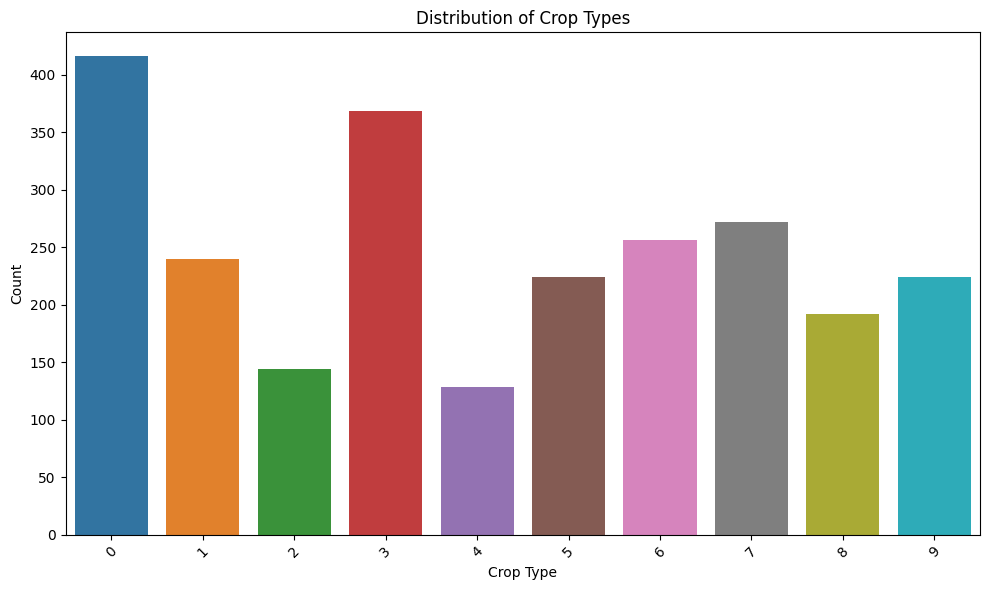

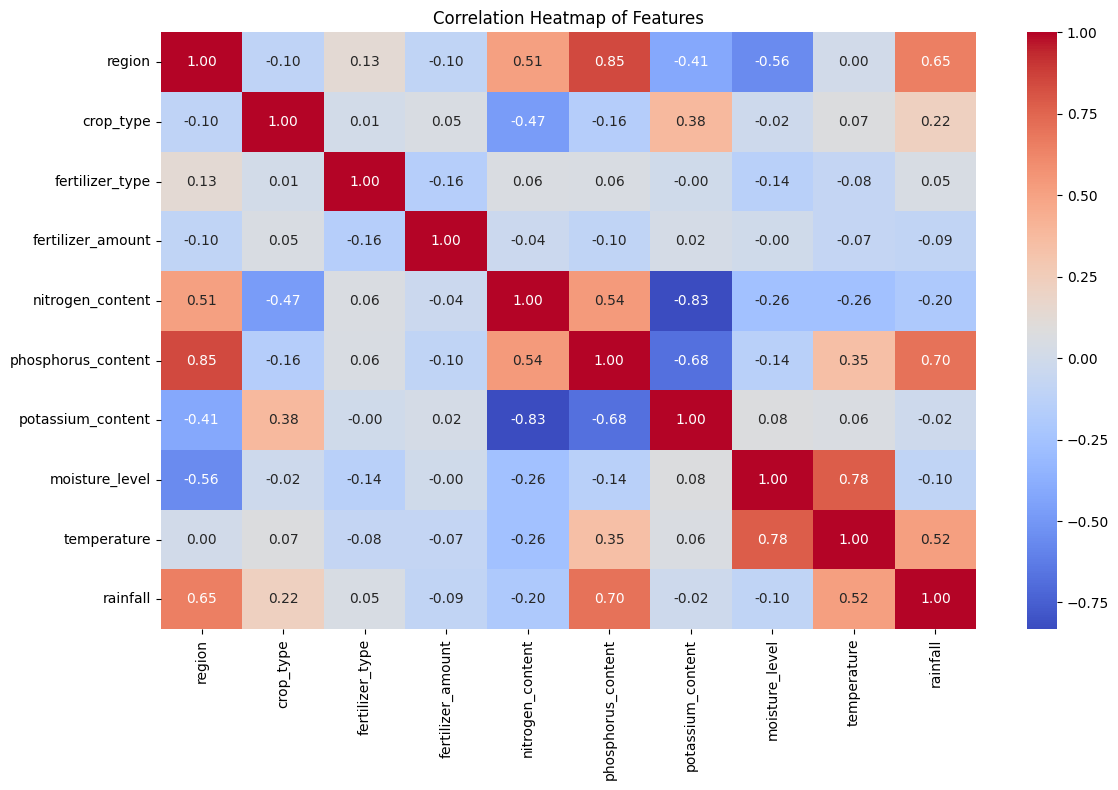

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


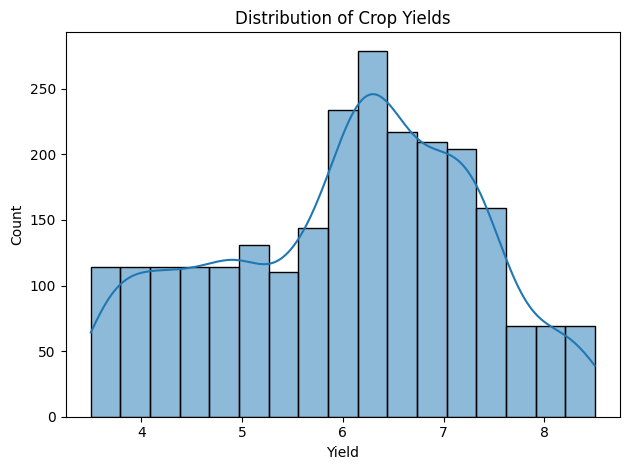

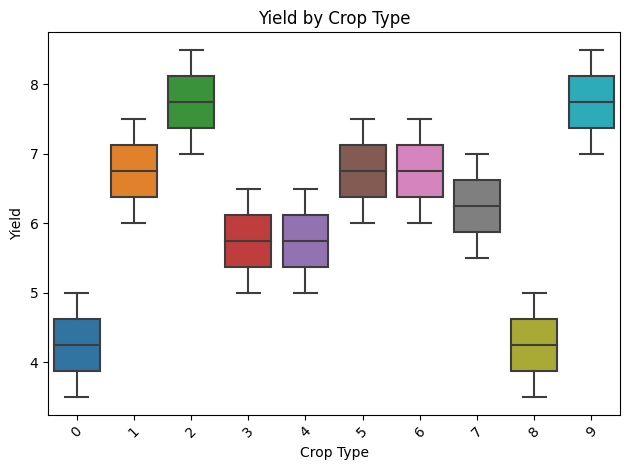

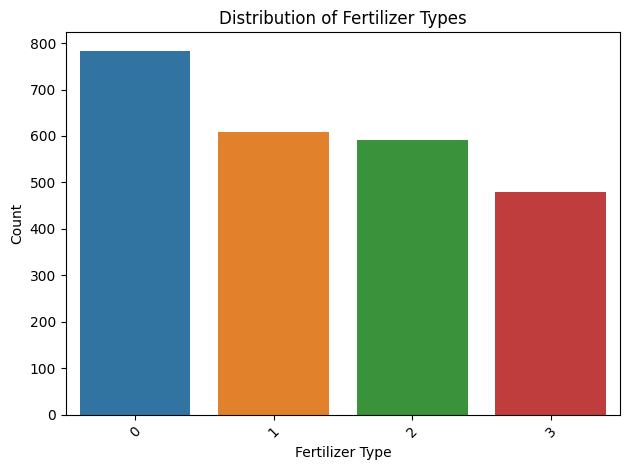

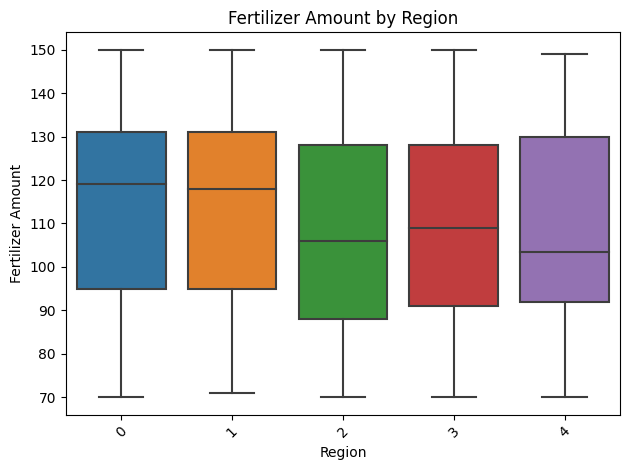

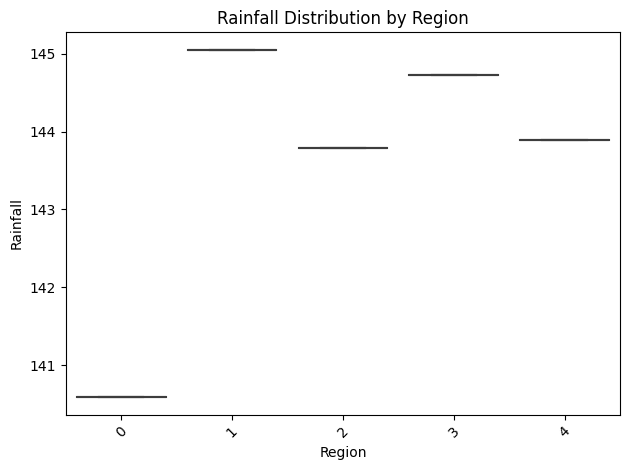

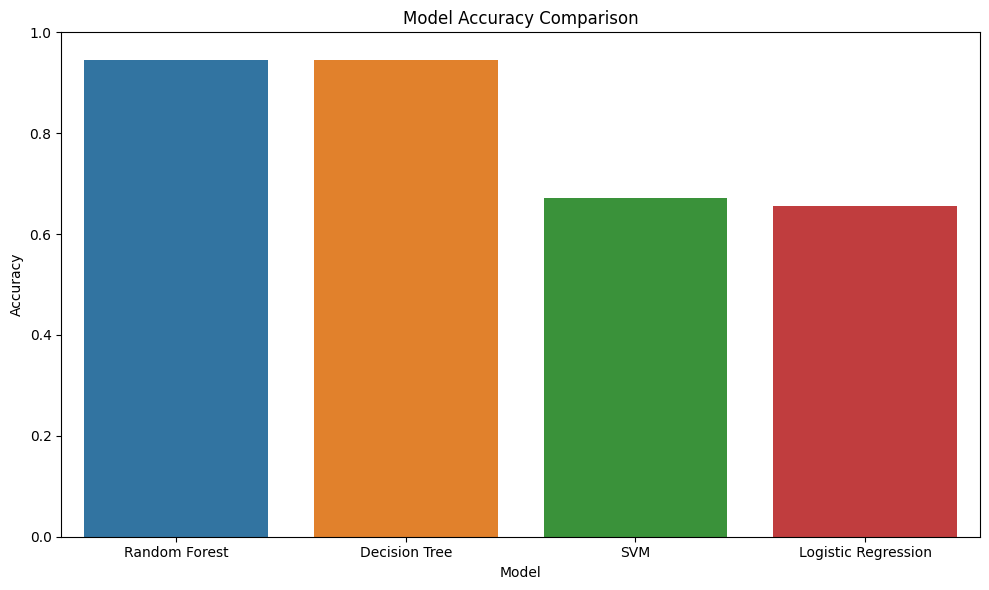

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
print("Available columns in the dataset:", df.columns.tolist())

# 1. Crop Type Distribution
if 'crop_type' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='crop_type', data=df)
    plt.title('Distribution of Crop Types')
    plt.xlabel('Crop Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'crop_type' not found.")

# 2. Correlation Heatmap
numeric_columns = df.select_dtypes(include='number').drop(columns=['yield'], errors='ignore')
if not numeric_columns.empty:
    plt.figure(figsize=(12, 8))
    correlation_matrix = numeric_columns.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Features')
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns available for correlation heatmap.")

# 3. Yield Distribution
if 'yield' in df.columns:
    plt.figure()
    sns.histplot(df['yield'], kde=True)
    plt.title('Distribution of Crop Yields')
    plt.xlabel('Yield')
    plt.tight_layout()
    plt.show()
else:
    print("Column 'yield' not found.")

# 4. Yield by Crop Type
if 'yield' in df.columns and 'crop_type' in df.columns:
    plt.figure()
    sns.boxplot(x='crop_type', y='yield', data=df)
    plt.title('Yield by Crop Type')
    plt.xlabel('Crop Type')
    plt.ylabel('Yield')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 5. Fertilizer Type Distribution
if 'fertilizer_type' in df.columns:
    plt.figure()
    sns.countplot(x='fertilizer_type', data=df)
    plt.title('Distribution of Fertilizer Types')
    plt.xlabel('Fertilizer Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'fertilizer_type' not found.")

# 6. Fertilizer Amount by Region
if 'fertilizer_amount' in df.columns and 'region' in df.columns:
    plt.figure()
    sns.boxplot(x='region', y='fertilizer_amount', data=df)
    plt.title('Fertilizer Amount by Region')
    plt.xlabel('Region')
    plt.ylabel('Fertilizer Amount')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 7. Rainfall by Region
if 'rainfall' in df.columns and 'region' in df.columns:
    plt.figure()
    sns.boxplot(x='region', y='rainfall', data=df)
    plt.title('Rainfall Distribution by Region')
    plt.xlabel('Region')
    plt.ylabel('Rainfall')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 8. Model Accuracy Comparison
if 'model_accuracies' in locals() or 'model_accuracies' in globals():
    model_accuracies_df = pd.DataFrame(model_accuracies, columns=['Model', 'Accuracy'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Accuracy', data=model_accuracies_df)
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
else:
    print("Model accuracy data not available.")
